In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gym
from gym import spaces

class DroneDeliveryEnv(gym.Env):
    def __init__(self, grid_size=6, stochastic=False, multiple_deliveries=False):
        super(DroneDeliveryEnv, self).__init__()
        
        self.grid_size = grid_size
        self.stochastic = stochastic
        self.multiple_deliveries = multiple_deliveries
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT', 'PICKUP', 'DROPOFF']
        self.no_fly_zones = {(1, 1), (2, 3), (4, 4)}  # Static no-fly zones
        self.reset()

        # Action and observation space
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size),  # x position
            spaces.Discrete(self.grid_size),  # y position
            spaces.Discrete(2)                # has_package (0 or 1)
        ))

    def reset(self):
        self.drone_position = (0, 0)  # Starting at the top-left corner (Warehouse)
        self.package_picked = False
        self.delivery_target = (self.grid_size - 1, self.grid_size - 1)  # Customer location (bottom-right corner)
        self.pickup_location = (0, 0)  # Pickup location (Warehouse)
        self.steps_taken = 0
        self.done = False
        self.total_reward = 0
        if self.multiple_deliveries:
            self.delivery_count = 0
        return self.drone_position + (self.package_picked,)

    def step(self, action):
        if self.done:
            raise Exception("Episode has ended. Reset the environment.")

        reward = -1
        new_position = list(self.drone_position[:2])
        if action == 0 and self.drone_position[0] > 0:  # UP
            new_position[0] -= 1
        elif action == 1 and self.drone_position[0] < self.grid_size - 1:  # DOWN
            new_position[0] += 1
        elif action == 2 and self.drone_position[1] > 0:  # LEFT
            new_position[1] -= 1
        elif action == 3 and self.drone_position[1] < self.grid_size - 1:  # RIGHT
            new_position[1] += 1

        # stochastic conditions
        if self.stochastic and random.random() < 0.1:  # 10% chance of deviation
            new_position = self._apply_stochastic_effect(new_position)

        new_position = tuple(new_position)
        if new_position in self.no_fly_zones:
            reward = -20
        else:
            self.drone_position = new_position

        # Pickup logic
        if action == 4 and self.drone_position == self.pickup_location and not self.package_picked:
            self.package_picked = True
            reward += 10  # Reward for picking up the package

        # Drop-off logic
        if action == 5 and self.drone_position == self.delivery_target and self.package_picked:
            reward = 20
            self.package_picked = False
            if self.multiple_deliveries:
                self.delivery_count += 1
                self._generate_new_target()
            else:
                self.done = True

        self.steps_taken += 1
        self.total_reward += reward

        return self.drone_position + (self.package_picked,), reward, self.done, {}

    # def render(self):
    #     grid = np.zeros((self.grid_size, self.grid_size))
    #     for z in self.no_fly_zones:
    #         grid[z] = -1
    #     grid[self.pickup_location] = 2
    #     grid[self.delivery_target] = 3
    #     grid[self.drone_position[0], self.drone_position[1]] = 1
    #     plt.imshow(grid, cmap="coolwarm", interpolation="nearest")
    #     plt.colorbar()
    #     plt.show()
    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size, 3))  # RGB grid
        fig, ax = plt.subplots()
        
        # Load images
        drone_empty = mpimg.imread("drone_empty.jpg")
        drone_loaded = mpimg.imread("drone_loaded.jpg")
        warehouse = mpimg.imread("warehouse.jpg")
        customer = mpimg.imread("customer.jpg")
        no_fly_zone = mpimg.imread("no_fly_zone.jpg")
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.no_fly_zones:
                    ax.imshow(no_fly_zone, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.pickup_location:
                    ax.imshow(warehouse, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
                if (i, j) == self.delivery_target:
                    ax.imshow(customer, extent=[j, j + 1, self.grid_size - i - 1, self.grid_size - i])
        
        # Drone position
        if self.package_picked:
            ax.imshow(drone_loaded, extent=[self.drone_position[1], self.drone_position[1] + 1, 
                                            self.grid_size - self.drone_position[0] - 1, 
                                            self.grid_size - self.drone_position[0]])
        else:
            ax.imshow(drone_empty, extent=[self.drone_position[1], self.drone_position[1] + 1, 
                                        self.grid_size - self.drone_position[0] - 1, 
                                        self.grid_size - self.drone_position[0]])
        
        ax.set_xticks(range(self.grid_size + 1))
        ax.set_yticks(range(self.grid_size + 1))
        ax.grid(True, which='both', color='black', linestyle='-', linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

    def _apply_stochastic_effect(self, position):
        deviations = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        deviation = random.choice(deviations)
        new_position = (position[0] + deviation[0], position[1] + deviation[1])
        return tuple(max(0, min(self.grid_size - 1, x)) for x in new_position)

    def _generate_new_target(self):
        self.delivery_target = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        while self.delivery_target in self.no_fly_zones:
            self.delivery_target = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        self.pickup_location = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        while self.pickup_location in self.no_fly_zones or self.pickup_location == self.delivery_target:
            self.pickup_location = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))



Running Deterministic Environment
Action: DROPOFF, State: (0, 0, False), Reward: -1, Done: False


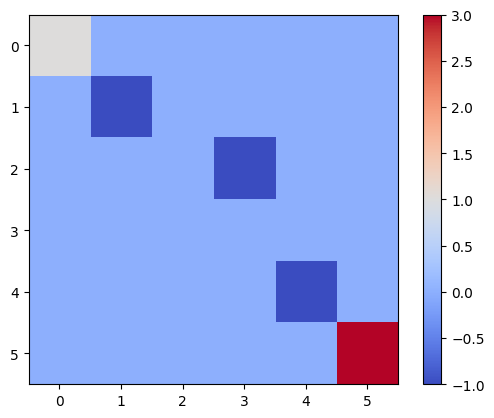

Action: DROPOFF, State: (0, 0, False), Reward: -1, Done: False


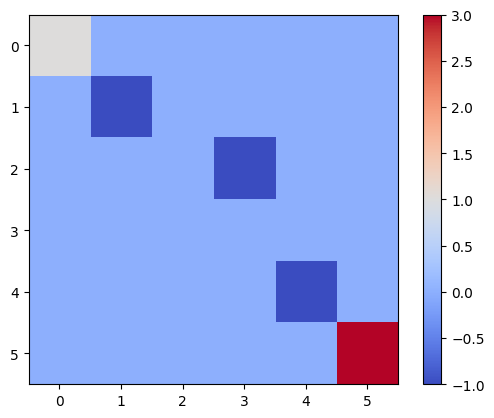

Action: PICKUP, State: (0, 0, True), Reward: 9, Done: False


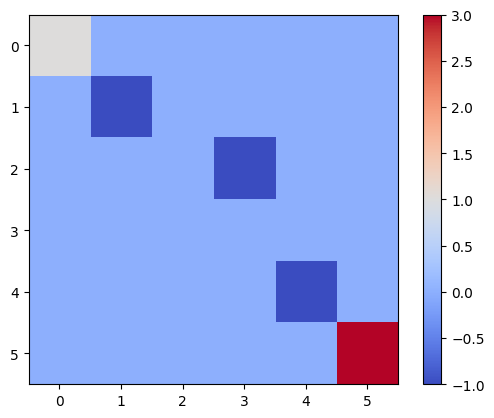

Action: UP, State: (0, 0, True), Reward: -1, Done: False


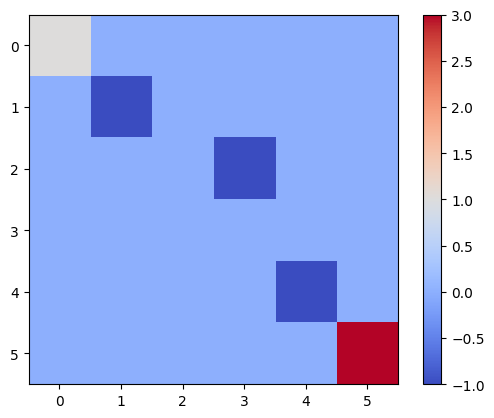

Action: UP, State: (0, 0, True), Reward: -1, Done: False


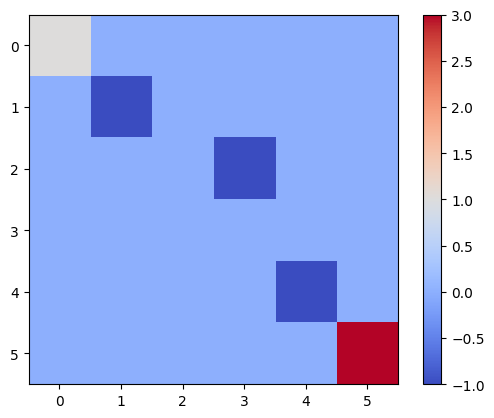

Action: DROPOFF, State: (0, 0, True), Reward: -1, Done: False


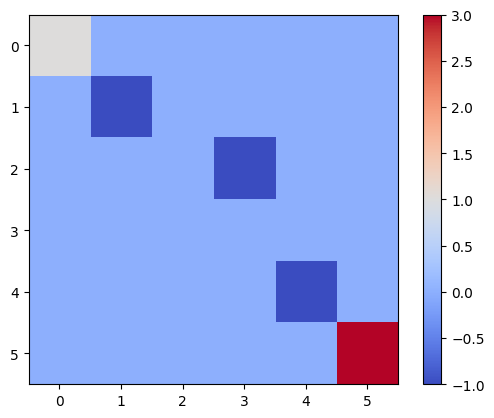

Action: UP, State: (0, 0, True), Reward: -1, Done: False


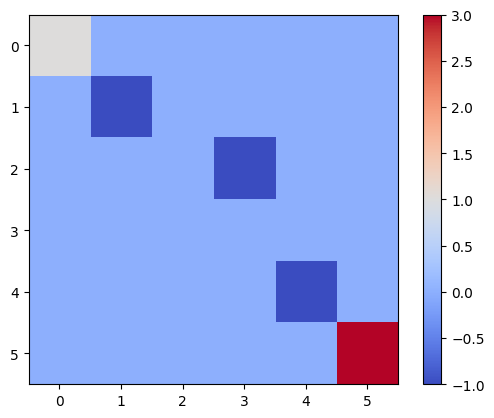

Action: RIGHT, State: (0, 1, True), Reward: -1, Done: False


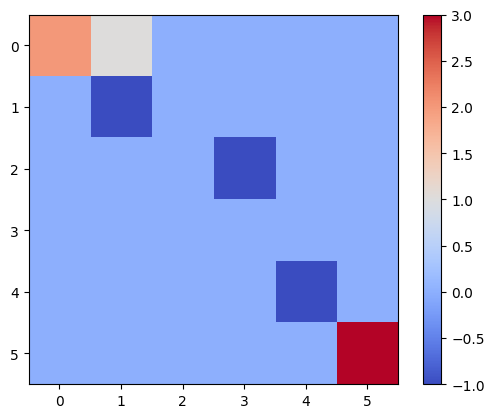

Action: PICKUP, State: (0, 1, True), Reward: -1, Done: False


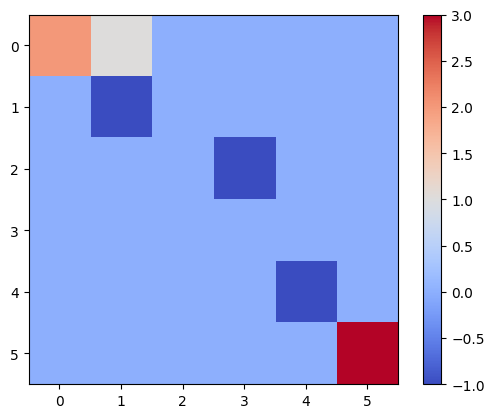

Action: RIGHT, State: (0, 2, True), Reward: -1, Done: False


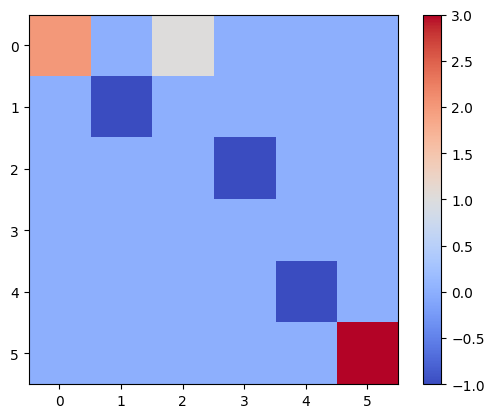

In [20]:
env_deterministic = DroneDeliveryEnv(stochastic=False, multiple_deliveries=False)
print("Running Deterministic Environment")
env_deterministic.reset()
for _ in range(10):
    action = random.randint(0, 5)  # Random action selection
    state, reward, done, _ = env_deterministic.step(action)
    print(f"Action: {env_deterministic.actions[action]}, State: {state}, Reward: {reward}, Done: {done}")
    env_deterministic.render()
    if done:
        print("Delivery Complete!")
        break

Running Stochastic Environment
Action: DOWN, State: (1, 0, False), Reward: -1, Done: False


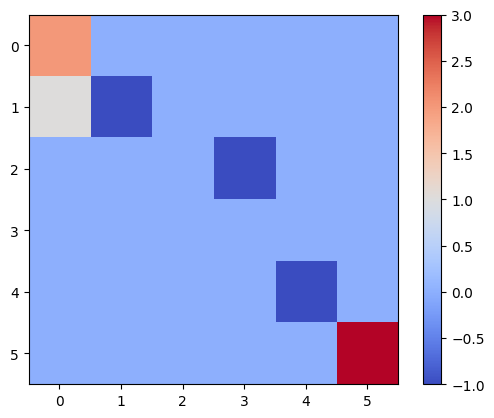

Action: RIGHT, State: (2, 1, False), Reward: -1, Done: False


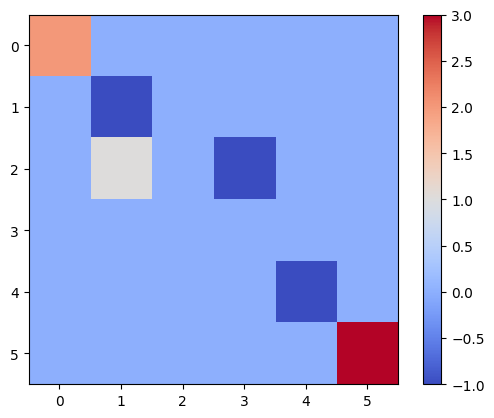

Action: UP, State: (1, 0, False), Reward: -1, Done: False


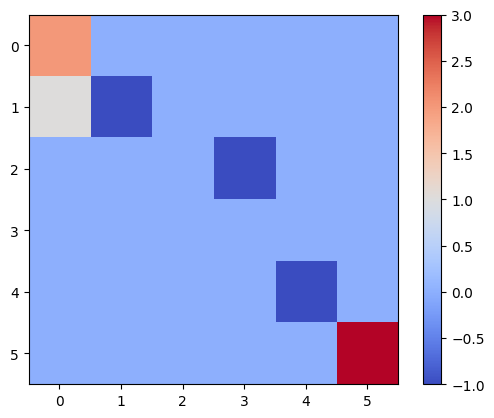

Action: UP, State: (0, 0, False), Reward: -1, Done: False


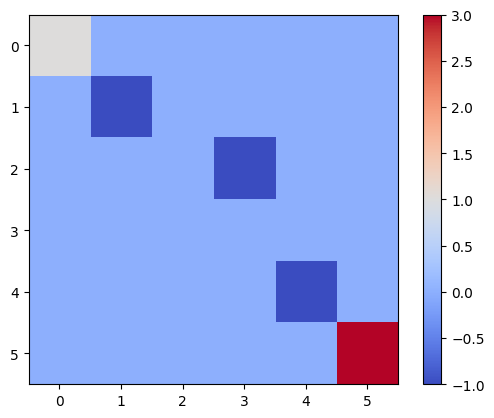

Action: PICKUP, State: (0, 0, True), Reward: 9, Done: False


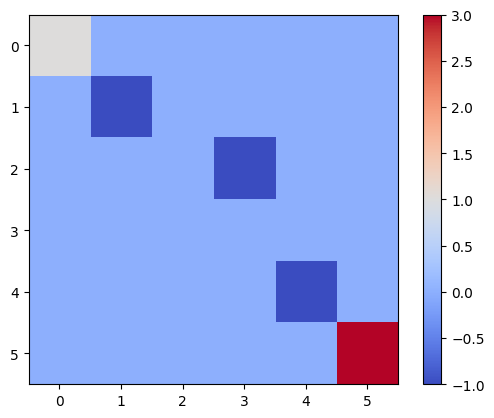

Action: UP, State: (0, 0, True), Reward: -1, Done: False


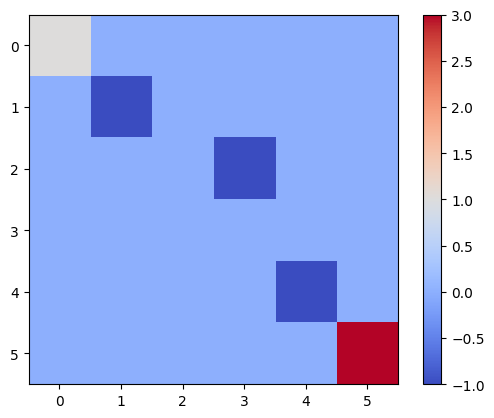

Action: RIGHT, State: (0, 0, True), Reward: -1, Done: False


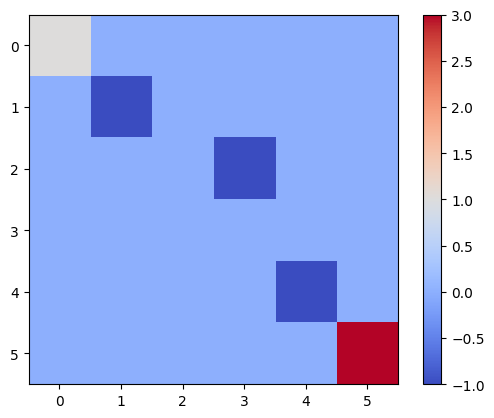

Action: PICKUP, State: (0, 0, True), Reward: -1, Done: False


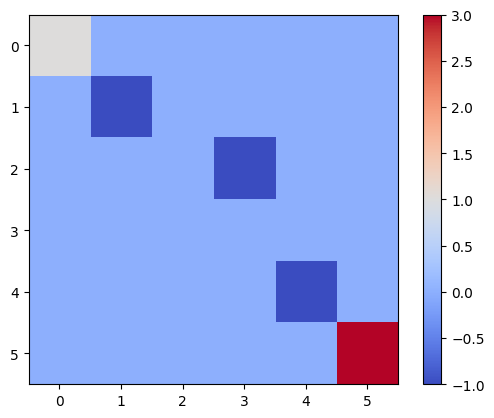

Action: DROPOFF, State: (0, 0, True), Reward: -1, Done: False


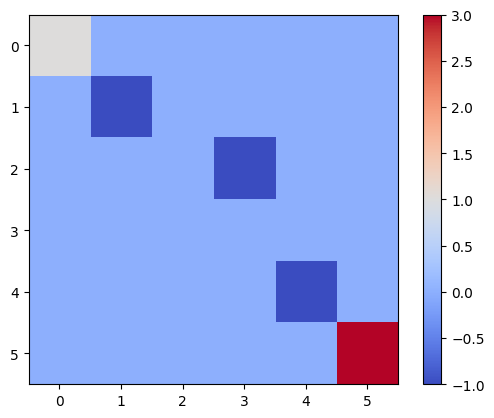

Action: UP, State: (0, 0, True), Reward: -1, Done: False


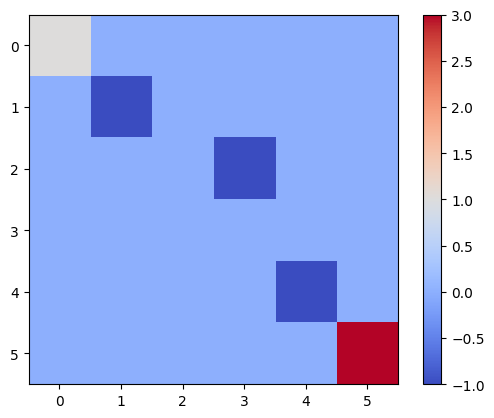

In [43]:
print("Running Stochastic Environment")
env_stochastic = DroneDeliveryEnv(stochastic=True, multiple_deliveries=False)
env_stochastic.reset()
for _ in range(10):
    action = random.randint(0, 5)  # Random action selection
    state, reward, done, _ = env_stochastic.step(action)
    print(f"Action: {env_stochastic.actions[action]}, State: {state}, Reward: {reward}, Done: {done}")
    env_stochastic.render()
    if done:
        print("Delivery Complete!")
        break

Running Deterministic Environment with multiple deliveries
Action: RIGHT, State: (0, 1, False), Reward: -1, Done: False


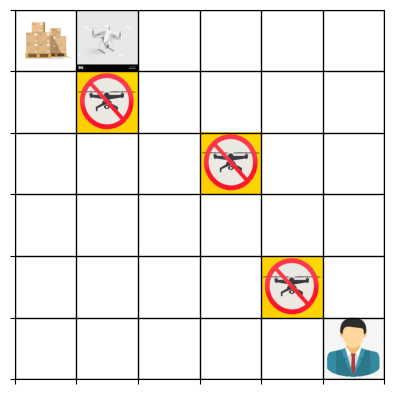

Action: RIGHT, State: (0, 2, False), Reward: -1, Done: False


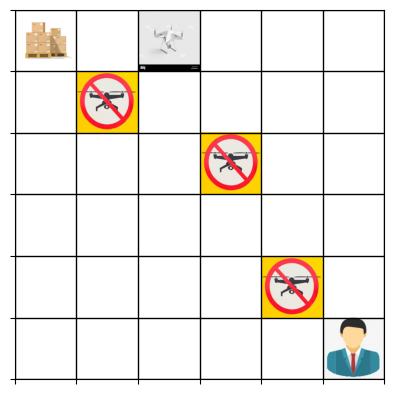

Action: PICKUP, State: (0, 2, False), Reward: -1, Done: False


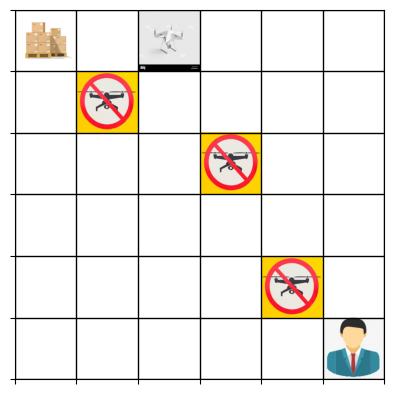

Action: RIGHT, State: (0, 3, False), Reward: -1, Done: False


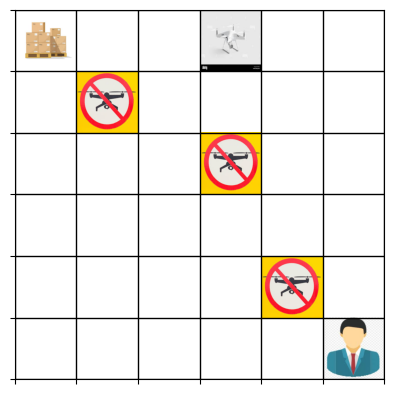

Action: LEFT, State: (0, 2, False), Reward: -1, Done: False


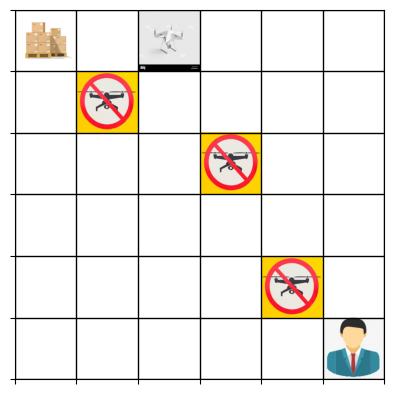

Action: LEFT, State: (0, 1, False), Reward: -1, Done: False


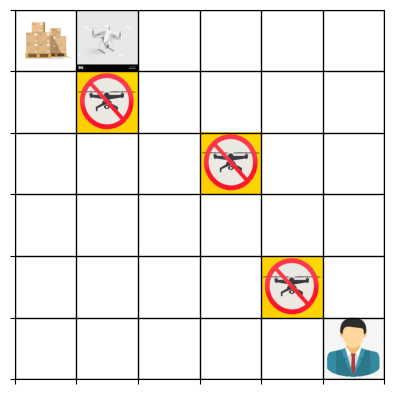

Action: PICKUP, State: (0, 1, False), Reward: -1, Done: False


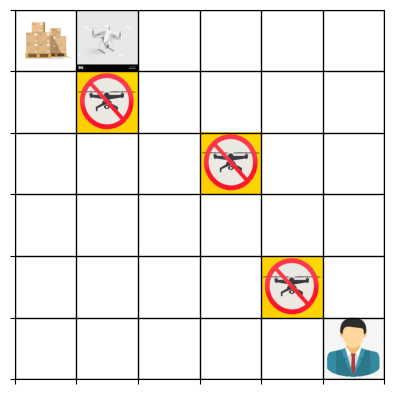

Action: DOWN, State: (0, 1, False), Reward: -20, Done: False


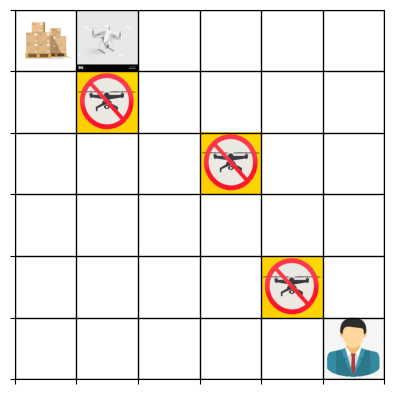

Action: PICKUP, State: (0, 1, False), Reward: -1, Done: False


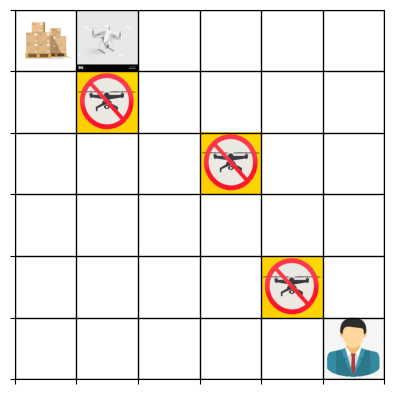

Action: DOWN, State: (0, 1, False), Reward: -20, Done: False


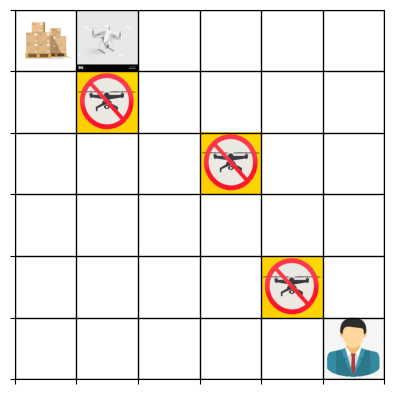

In [5]:
env_deterministic = DroneDeliveryEnv(stochastic=False, multiple_deliveries=True)
print("Running Deterministic Environment with multiple deliveries")
env_deterministic.reset()
for _ in range(10):
    action = random.randint(0, 5)  # Random action selection
    state, reward, done, _ = env_deterministic.step(action)
    print(f"Action: {env_deterministic.actions[action]}, State: {state}, Reward: {reward}, Done: {done}")
    env_deterministic.render()
    if done:
        print("Delivery Complete!")
        break